# **FAISS library for** 

b) exhaustive search

c) product quantization

d) trees and graphs

e) hnsw

**Installing and importing libraries**

In [15]:
! pip install nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 14.8 MB/s 


In [21]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (378 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Se

In [22]:
! pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import nmslib
import annoy
import faiss    

In [24]:
digits = load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
X.shape

(901, 64)

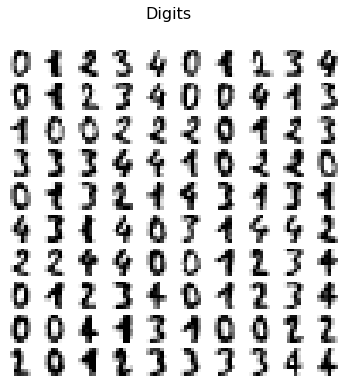

In [26]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Digits", fontsize=16)

In [27]:
from sklearn.manifold import TSNE

tsne_2 = TSNE()
data_embeddings_tsne_2 = tsne_2.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [28]:

data_embeddings_tsne_2.shape


(901, 2)

In [31]:
hnsw_index = nmslib.init(method='hnsw', space='cosinesimil')
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})

In [32]:
y[80]
    

0

In [33]:
hnsw_output = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k=10)
hnsw_output_list = [y[i] for i in hnsw_output[0]]
hnsw_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**Exhaustive Search**

In [35]:
exhaustive_search = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
exhaustive_search.add(data_embeddings_tsne_2)
     

distances, indices = exhaustive_search.search(data_embeddings_tsne_2[80:81], 10) 
exhaustive_search_output_list = [y[i] for i in indices[0]]
     

exhaustive_search_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
y[80]

0

In [37]:
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[90:91], 10) 
exhaustive_search_output_list_2 = [y[i] for i in indices[0]]
exhaustive_search_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [38]:
y[90]

2

**Product Quantization**

In [40]:
number_of_partition = 8
search_in_x_partitions = 2
subvector_size = 8

In [42]:
pq_quantizer = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
pq = faiss.IndexIVFPQ(pq_quantizer, data_embeddings_tsne_2.shape[1], number_of_partition, search_in_x_partitions, subvector_size)
pq.train(data_embeddings_tsne_2)
pq.add(data_embeddings_tsne_2)
     



In [43]:
distances, indices = pq.search(data_embeddings_tsne_2[90:91], 10) 
pq_output_list =  [y[i] for i in indices[0]]
pq_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [44]:
y[90]

2

**Treea and Graphs**

In [45]:
number_of_trees = 5
annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])
for i, vec in enumerate(data_embeddings_tsne_2):
  annoy_index.add_item(i, vec.tolist())
annoy_index.build(number_of_trees)

<ipython-input-45-e161fd0a985a>:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])


True

In [46]:
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[90].tolist(), 10)
annoy_output_list = [y[i] for i in annoy_indices]

annoy_output_list 

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [48]:
y[90]

2

In [47]:
graph_index = faiss.IndexHNSWFlat(data_embeddings_tsne_2.shape[1], 10)
graph_index.add(data_embeddings_tsne_2)

distances, indices = graph_index.search(data_embeddings_tsne_2[90:91], k=10)
graph_output_list = [y[i] for i in indices[0]]
graph_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [49]:
y[90]

2

**HNSW (Hierarchical Navigable Small Worlds)**

In [50]:
hnsw_index = nmslib.init(method='hnsw', space='cosinesimil')
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})


In [51]:
hnsw_output_1 = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k=10)
hnsw_output_list_1 = [y[i] for i in hnsw_output_1[0]]
hnsw_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
hnsw_output_2 = hnsw_index.knnQuery(data_embeddings_tsne_2[90], k=10)
hnsw_output_list_2 = [y[i] for i in hnsw_output_2[0]]
hnsw_output_list_2


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [53]:
y[90]

2